In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = '\dataset'
labels_dir = data_dir+'\\train.csv'

Y = pd.read_csv(os.getcwd()+labels_dir,dtype=str)

In [3]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import shutil

In [4]:
labels = Y['Class']
unique_labels = labels.unique()
image_names = Y['Image']

In [5]:
## Creating Directories
def create_directories(unique_labels,directory):
    
    try:
        for unique in unique_labels:
            os.mkdir(directory+unique)
    
    except:
        print("Some Error Occured")
        
    else:
        print("Created Corresponding Directories")

#create_directories(unique_labels,'.'+data_dir+'\\train\\')

In [6]:
image_dir  = '.'+data_dir+'\\train\\' 

## Segregate Images to Directories
def move_images(image_names):
    for i in range(len(image_names)):
        try:        
            shutil.move(image_dir+image_names[i],image_dir+labels[i])
            print("%s Copied to %s"%(image_names[i],labels[i]))
        except:
            print("Error in Copying")
            continue

#move_images(image_names)

In [7]:
from tensorflow import keras

def load_model():
    return keras.models.load_model('Xception_update')

def save_model(model):
    model.save("Xception_update")

In [8]:
#model = load_model()

## Image Generators for Training and Validation

In [73]:
datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2)

train_generator = datagen.flow_from_directory(
    image_dir,
    target_size=(128, 128),
    batch_size=8,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = datagen.flow_from_directory(
    image_dir, # same directory as training data
    target_size=(128, 128),
    batch_size=8,
    class_mode='categorical',
    subset='validation')

Found 5177 images belonging to 6 classes.
Found 1292 images belonging to 6 classes.


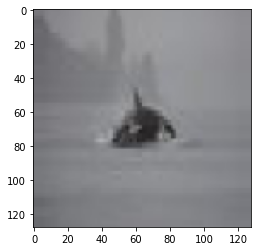

In [74]:
img = train_generator.next()
plt.imshow(img[0][0])

In [75]:
import tensorflow as tf
from tensorflow.keras import layers, Sequential

In [76]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss',patience=1)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-2 * 10**(epoch / 20))

In [105]:
def generate_model(num_classes,img_shape):

    model = Sequential([
      layers.Conv2D(64,(2,2),input_shape=img_shape),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(32, activation='relu'),
      layers.Dense(16,activation='tanh'),
      layers.Dense(8,activation='relu'),
      layers.Dense(num_classes,activation='softmax')
    ])
    
    model.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])
    
    return model

model = generate_model(6,(128,128,3))


In [ ]:
history = model.fit(train_generator,validation_data=validation_generator,epochs=50)

Epoch 1/50
648/648 [==============================] - 370s 572ms/step - loss: 1.6138 - accuracy: 0.4002 - val_loss: 1.5217 - val_accuracy: 0.4334
Epoch 2/50
648/648 [==============================] - 361s 558ms/step - loss: 1.5224 - accuracy: 0.4329 - val_loss: 1.5192 - val_accuracy: 0.4334
Epoch 3/50
191/648 [=======>......................] - ETA: 4:07 - loss: 1.5249 - accuracy: 0.4346

In [ ]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-5, 1e-2, 1, 2])

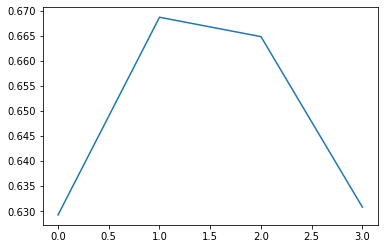

In [87]:
plt.plot(history.history['val_accuracy'])

In [ ]:
## Saving The Model
save_model(model)

## Generating Predictions

In [88]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    './dataset/test_1',
    target_size=(128, 128),
    batch_size=8)

Found 3489 images belonging to 1 classes.


In [89]:
preds=model.predict(test_generator)
predicted_class_indices=np.argmax(preds,axis=1)

In [90]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [91]:
filenames=test_generator.filenames
for i in range(len(filenames)):filenames[i] = filenames[i][5:]

results=pd.DataFrame({"Image":filenames,
                      "Class":predictions})

In [92]:
results

,Image,Class
0,image10.jpg,Miscellaneous
1,image100.jpg,Miscellaneous
2,image1013.jpg,Miscellaneous
3,image1014.jpg,Miscellaneous
4,image1018.jpg,Christmas_Tree
...,...,...
3484,image9953.jpg,Miscellaneous
3485,image9956.jpg,Miscellaneous
3486,image9958.jpg,Miscellaneous
3487,image9960.jpg,Miscellaneous
